In [2]:
import sys
sys.path.insert(0, '/Users/kedzie/repos/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import bokeh
import scipy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import read_data, read_press, getnearpos, folder_files, headspace
from utility_functions.utils import getnearpos

In [3]:


#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    
    m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    m = [1.463, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    inf_ar = 288.7462016 * demsdata['36']
    
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
       
    return (demsdata) 


def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    index = getnearpos(data['time/min'], end1/60)
    index2 = getnearpos(data['time/min'], start2)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--')

    
    if mz == 2:
        #cell 17 4/26 correction1: 
        #correct= -1.19042*10**-5*data['time/min'] + 4.70975*10**-3
        #cell 18 correct= 5.45705*10**-12*data['time/min']**4 - 3.48588*10**-9*data['time/min']**3 + 8.38975*10**-7*data['time/min']**2 - 8.88079*10**-5*data['time/min']+5.55649*10**-3
        # correct = -0.2179834 * data['time/min'] + 2.396152*10**2 #cell 17 with ar
        #cell 19 correct = -7.99561*10**-7 * data['time/min'] + 2.99082*10**-3
        #cell 20
        #correct = -1.56453*10**-6* data['time/min'] + 3.58403*10**-3
        #correct = -2.32525*10**-6*data['time/min'] + 8.70813*10**-4
       # correct = 0.03149263*(data['time/min'])**(-0.08346832)
        #correct =  0.0314373*data['time/min']**(-8.27992*10**-2) #5/25/19 cell 1
        correct = 2.81138*10**-2*data['time/min']**(-5.04060*10**-2)-0.001 #5/25 cell2
    elif mz == 32:
        #correct = 0*data['time/min']+0.0047
        correct = 0*data['time/min']+0.0055
        
    elif mz ==44:
        
        correct = -1.78492*10**-6*data['time/min'] + 1.32791*10**-2 +0.001
    plt.plot(data['time/min'], correct, '.')
    
    data[str(mz)] = data[str(mz)]-correct
    
    return (data)



In [4]:
def plot_naion_dems(chrg_ec, demi, mass_mg, i_uA):
    num = len(chrg_ec)
    print(num)
    end_ocv= chrg_ec[0]['time/s'].iloc[-1] 
    index1 = getnearpos(demi['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)

    mass_mg= (mass_mg-28.6)*0.8
    #convert ion current to moles of gas for raw  data
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    hydro = baselinecorr( demi, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( demi, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    o2 = baselinecorr( demi, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    umolesdf = o2
    
    #pdb.set_trace()
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    print(timediff)
    fig,ax = plt.subplots(facecolor='white')
    ax2=ax.twinx()
    
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1]
    startcap=umolesdf['time/min'].iloc[index1]/60*i_uA/mass_mg
    
    
    print('start capacity: '+ str(startcap))
    
    ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['2'][index1:])/timediff , 'o', markersize=2, label= '2')
    ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['44'][index1:])/timediff , 'o', markersize=2, label= '44')
    ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['32'][index1:])/timediff , 'o', markersize=2, label= '32')
    
    for i in range(num-1):
        ax.plot(chrg_ec[i+1]['time/s']/3600*i_uA/mass_mg-startcap , chrg_ec[i+1]['Ewe/V'] , color='xkcd:blue')
    
    #ax.fill_between([27,32], 1.4, color='xkcd:blue', alpha=0.2)
    #ax.fill_between([143,176], 1.4, color='xkcd:blue', alpha=0.2)
    #ax2.spines['right'].set_color('red')
    ax2.tick_params(axis='y')#, colors='red')
    ax.spines['left'].set_color('xkcd:blue')
    ax.tick_params(axis='y', colors='xkcd:blue')
    
    ax.set_xlabel('Capacity [mAh/g]')
    ax.set_ylabel('U [V]' , color='xkcd:blue')
    ax2.set_ylabel('Molar Flux of Gas [$\mu$mol/min]')#, color='red')
    ax2.legend()
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    
    #umolesdf.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/nacell2_finalvalues.csv')


    return

5
5.0206485
start capacity: 24.841687750000002


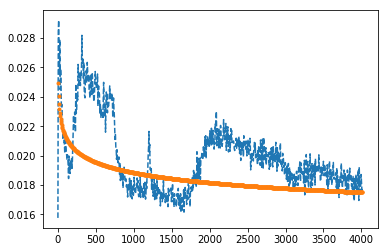

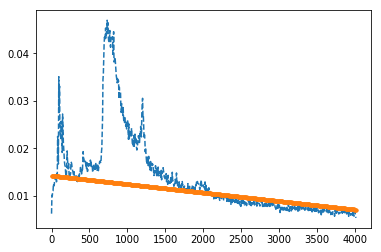

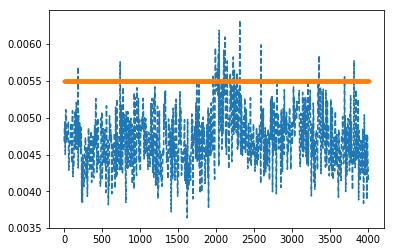

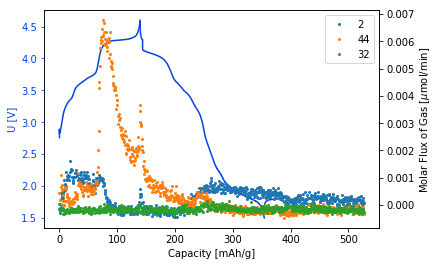

In [162]:
na1= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample1/')
na1_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample1/190524_Naion_xiaolitest_dems_sample1_2019-05-24_11.15_12_ch1.txt')
#umolesna1 = convert_ion_current(na1_dems) 
#umolesna1.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/nacell1.csv')

plot_naion_dems(na1, na1_dems, 42.9, 94.38)

5
5.0206459062499995
start capacity: 24.90242748648649


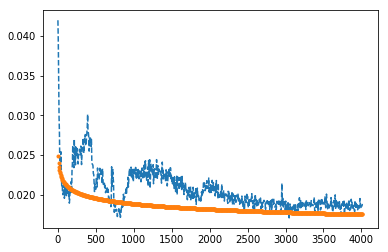

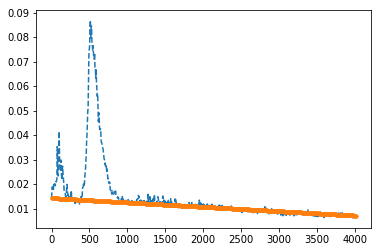

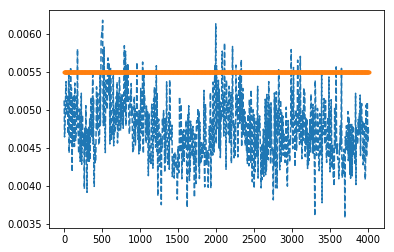

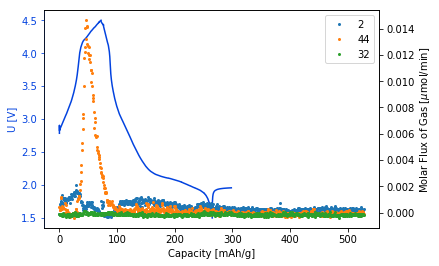

In [7]:
na2= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample2/')
na2_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample2/190524_Naion_xiaolitest_dems_sample2_2019-05-24_11.15_12_ch2.txt')

#umolesna = convert_ion_current(na2_dems) 
#umolesna.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrents_naion_cell2.csv')



plot_naion_dems(na2, na2_dems, 43.4, 97.92)
#plt.savefig('/Users/kedzie/Desktop/na s2e1 dems.png', transparent = True, dpi=600, bbox_inches='tight')



5
9.981013722627734
start capacity: -31.409090515759306


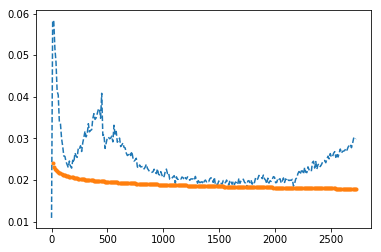

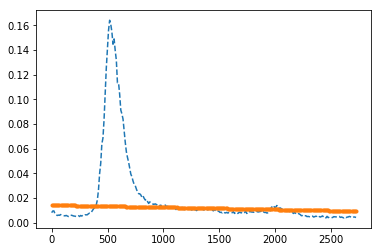

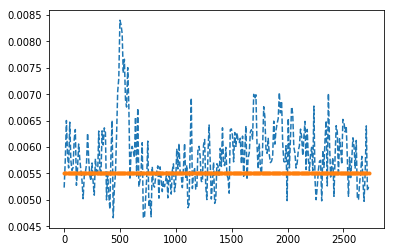

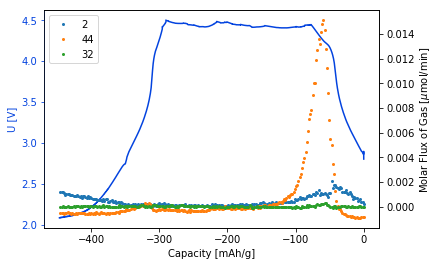

In [165]:
natrial2=folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190601_Naion_xiaoli_dems_e2sample2/')
natrial2_dems=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190601_Naion_xiaoli_dems_e2sample2/190601_Naion_xiaoli_dems_e2sample2_2019-06-01_12.50_02.txt')

plot_naion_dems(natrial2, natrial2_dems, 14.64, 117.12)
#plt.savefig('/Users/kedzie/Desktop/na s2e2 dems.png', transparent = True, dpi=600, bbox_inches='tight')
